<a href="https://colab.research.google.com/github/Kobajojn/FYRP_U-Net_Architecture/blob/main/U_net_Architecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
!pip install tacoreader rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 41.5 MB/s eta 0:00:00


Text(0.5, 1.0, 'Human label')

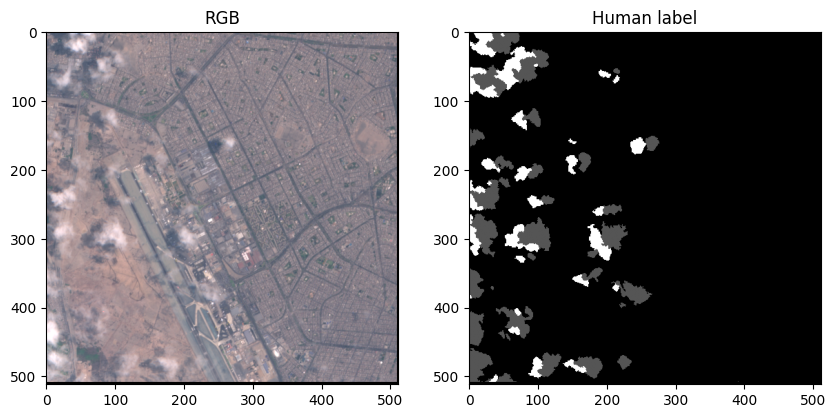

In [2]:
# @Setup and accessing CloudSEN12+
# TODO REWRITE WHOLE SECTION - COPIED

import logging
import matplotlib.pyplot
import matplotlib.pyplot
import numpy
import tacoreader
import rasterio as rio
import torch
import torch.nn as nn

# Select one image from the test dataset
ds = tacoreader.load("tacofoundation:cloudsen12-l1c")
subset = ds[(ds["tortilla:data_split"] == "test") & (ds["label_type"] == "high") & (ds["real_proj_shape"] == 509)] #splits the file into segments - rewrite - from tacoreader library

# Read only one sample
sample_idx = 271
s2_l1c = subset.read(sample_idx).read(0)
s2_label = subset.read(sample_idx).read(1)

# Retrieve the S2 data - EDIT TO BE MORE READABLE
with rio.open(s2_l1c), rio.open(s2_label):
    s2_l1c_data = rio.open(s2_l1c).read(window=rio.windows.Window(0, 0, 512, 512)) / 10_000   # (13, 512, 512) ndarray (numpy)
    s2_label_data = rio.open(s2_label).read(window=rio.windows.Window(0, 0, 512, 512))        #var is a string with links to hugging face

# Graphing image with human determined labels
datapoint_rgb = numpy.moveaxis(s2_l1c_data[[3, 2, 1]], 0, -1) * 3  #REWRITE - ensure that the dimensionality exploited is the colour channels #TODO understand technique
fig, ax = matplotlib.pyplot.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(datapoint_rgb)
ax[0].set_title("RGB")
ax[1].imshow(s2_label_data[0], cmap="gray")
ax[1].set_title("Human label")

In [3]:
# initalise and set up the logger application
logger = logging.getLogger(__name__)

logging.basicConfig(
    #filename = "logging.txt",  # logger is saved to file instead of shown on the console
    encoding = "ASCII",
    format = "%(asctime)s %(name)s %(levelname)s:\t%(message)s",
    level = logging.INFO,
    force = True
)

# Misc Functions

In [4]:
def tensor_info(tensor_input, tensor_name):
  """
  Prints off a list of the tensor's details including:  \
    Datatype, Shape, Size, and the device location stored in memory

  foward() Args:
    tensor_input (tensor) - tensor to be examined.
    tensor_name (string) - a string description of the tensor used for descriptive purposes

  return:
    None
  """
  logger.info(f"Tensor:\t\t\t{tensor_name}")
  logger.info(f"Output Datatype:\t{tensor_input.dtype}")
  logger.info(f"Output Shape:\t\t{tensor_input.shape}")
  logger.info(f"Output Size:\t\t{tensor_input.size()}")
  logger.info(f"Output Device:\t\t{tensor_input.device}"
      f"\n--------------------------------------------------------\n")
  return None

In [5]:
def mash_colour_channel(img):
  """
  Generate a greyscale image of a tensor with more than 3 colour/feature channels. \
    Use primarily for visualisation and debugging purposes of prior transformations.

  foward() Args:
    img (tensor) - The input image. Image format is [z, x, y] or [w, u, v]. \
      2D images can also used used in format [x, y] or [u, v]

  return:
    None
  """
  # uses ".unsqueeze(0)" to add an extra dimension for 2D images.
  if img.dim() == 2:
    img = img.unsqueeze(0)

  # Temporary - converts from Tensor to numpy - TODO: understand why detach is needed
  img = img.detach().numpy()
  z_size = img.shape[0] # Gathers the size of the z or colour element

  # averages out the colour channel elementwise - main transformation of function
  img_no_colour = numpy.mean(a = img, axis = 0)

  # display image dimension characterisitics and print the image
  logger.info(f"The image resolution is {img_no_colour.shape}")
  logger.info(f"The number of colour channels are {z_size}")
  matplotlib.pyplot.gray() # place the image output into greyscale
  matplotlib.pyplot.imshow(img_no_colour)
  matplotlib.pyplot.show()
  return None

# Encoder Layer

In [6]:
device = 'cpu'

# ENCODER LAYER - going "down the U"; i.e decreasing the resolution at the for more colour channels

class conv_layer(nn.Module):
  """
  Decreases the spatial resolution of the image for more colour/feature channels.
    Used in both encoder and decoder segments.
    Applies a convolution (3x3) and ReLU to the image twice to the image.
    1x convolution reduces the resolution by 2 pixels and 2x the colour channels.

  class() Args:
    channels_in (int) - The no. of colour/feature channels of the input img.
  foward() Args:
    img (tensor float32) - The input image. Image format is [z, x, y] or [w, u, v]

  return:
    output (tensor float32) - The output image after transformations.
  """
  def __init__ (self, channels_in, up_sample = True): # Parameters go here!
    super().__init__()

    if up_sample:
      out_channels = channels_in * 2
    else:
      out_channels = int(channels_in / 2)

    # Convolution 1 - a sliding window function
    self.conv1 = nn.Conv2d(
        in_channels = channels_in,
        out_channels = out_channels,
        kernel_size = 3,
        stride = 1,
        # padding = 1,                    # padded with zeros to ensure dimensions are always even
        # padding_mode = 'zeros',         # [30] recommends an unpadded convolution
        # bias = True # defaults to True - is a learned bias to Output
        dtype = torch.float32
    )
    # Convolution 2 - a sliding window function
    self.conv2 = nn.Conv2d(
        in_channels = out_channels,
        out_channels = out_channels,
        kernel_size = 3,
        stride = 1,
        dtype = torch.float32
    )
    # Rectified Linear Unit 1 - A non-linear activation function
    self.relu = nn.ReLU()

  def forward(self, img):
    output = self.conv1(img)
    output = self.relu(output)
    output = self.conv2(output)
    output = self.relu(output)
    return output


class encoder_layer(nn.Module):
  """
  Decreases the spatial resolution of the image for more colour/feature channels.
    Main core segment of the encoder stage.
    Applies a convolution (3x3) and ReLU to the image twice then (2x2) pool to the image.

    1x pooling downsamples the resolution by x0.5.

  class() Args:
    channels_in (int) - The no. of colour/feature channels of the input img.
  foward() Args:
    img (tensor float32) - The input image. Image format is [z, x, y] or [w, u, v]

  return:
    postpool_output (tensor float32) - The output image after pooling.
    prepool_output (tensor float32) - The output image before pooling. Used in concatenation.
  """
  def __init__ (self): # Parameters go here!
    super().__init__()

    # A 2x2 kernal is used, with a stride/offset of 2 pixels
    self.pooling = nn.MaxPool2d(
        kernel_size = (2, 2),
        stride = 2,
    )

  def forward(self, img, channels_in):
    conv_forward = conv_layer(channels_in = channels_in)
    output = conv_forward(img)

    prepool_output = output
    postpool_output = self.pooling(output) # Final transformation to image

    return postpool_output, prepool_output


# Decoder Layer

In [7]:
# DECODER LAYER - going "up the U"; i.e increasing the resolution at the expense of less colour channels

class decoder_layer(nn.Module):
  """
  Increases the spatial resolution of the image for less colour/feature channels.
    Apply a (2x2) "deconvolution" transformation to counteract the impacts of pooling and convolution.
    Then a "concatenation_feature()" is applied to double colour channel size.
    The main building block of the decoder side of the U-net model.
    1x deconvolution increases the resolution 2x and the colour channels by x0.5.
    1x "concatenation_features()" to the image (doubles colour channel)

  class() Args:
    channels_in (int) - The no. of colour/feature channels of the input img.

  crop_and_concat() Args:
    img_decoder (tensor float32) - Deconvoluted image from decoder side.
      Image format is [z, x, y] or [w, u, v].
      Only works if [x, y] dimensions are EVEN.
    img_encoder_skip (tensor float32) - Pooled image from encoder side. Larger than img_deconv
      Image format is [z, x, y] or [w, u, v]

  foward() Args:
    img (tensor) - The input image. Image format is [z, x, y] or [w, u, v]

  return:
    output (tensor) - The increased spatial resolution image.
  """
  def __init__ (self, channels_deconv_in):
    super().__init__()

    self.deconv1 = nn.ConvTranspose2d(
        in_channels = channels_deconv_in,
        out_channels = int(channels_deconv_in / 2),
        kernel_size = [2, 2], # Deconvolute the image with a 2x2 kernal
        stride = 2,           # to significantly increase the resolution
        dtype = torch.float32
    )

  def crop_and_concat(self, img_decoder, img_encoder_skip):
    """
    Doubles the feature channels of its input image.
      Crops prepool_output from the encoder layer and then concatenates its colour/
      feature channels with the decoder's respective deconvoluted image.

    Args:
      img_decoder (tensor float32) - Deconvoluted image from decoder side.
        Image format is [z, x, y] or [w, u, v].
        Only works if [x, y] dimensions are EVEN.
      img_encoder_skip (tensor float32) - Pooled image from encoder side. Larger than img_deconv
        Image format is [z, x, y] or [w, u, v]

    Returns:
      img_concat (tensor float32) - image with double the inputs colour channels
    """
    # Determining the range of the cropping
    size_difference =  img_encoder_skip.shape[1] - img_decoder.shape[1]
    logger.debug(f"size_difference = {size_difference}")
    logger.debug(f"img_encoder_skip.shape = {img_decoder.shape}")
    logger.debug(f"img_decoder.shape = {img_decoder.shape}")

    lower_range = int(size_difference / 2)
    upper_range = img_decoder.shape[1] + lower_range

    # Only works if dimensions are even
    if size_difference % 2 == 0:
      logger.debug(f"The image dimensions are EVEN. Thus cropping can be applied.")

      # Crop the encoded image to fit the resolution of the reduced (in dimensions) decoded image
      img_encoder_crop = img_encoder_skip[:, lower_range:upper_range, lower_range:upper_range]
      # tensor_info(img_decoder, "[ORIGINAL] img_decoder")
      # tensor_info(img_encoder_crop, "[CROPPED] img_encoder_crop")

      # concatenate the colour/feature channels of the encoder and decoder imgs.
      img_concat = torch.cat(tensors = (img_decoder, img_encoder_crop), dim = 0)
      # tensor_info(img_concat, "[COMBINED] img_concat (combined colour channels)")
      # mash_colour_channel(img_concat)

      return img_concat

    else:
      logger.info(f"The image dimensions are ODD. Thus cropped can NOT be applied."
        f"Please crop the image for a EVEN dimension.")
      return None

  def forward(self, img_decoder, img_encoder_skip, channels_in):
    # deconvolute (decrease features, increasing x,y size) + crop and concatenate (x2 feature channels)
    output = self.deconv1(img_decoder)
    output = self.crop_and_concat(img_decoder = output, img_encoder_skip = img_encoder_skip)

    # Apply 2x convolutions + 2x ReLU
    conv_layer_1 = conv_layer(channels_in = channels_in, up_sample = False)
    output = conv_layer_1(output)
    return output

# Bringing it all together

In [8]:
""" ---VARIABLE NAMING NOMENCLATURE:---
- Alphabetical images correspond to which layer the image was generated on.
e.g. B_pooled is on layer 2.
- "X_pooled" are images generated with 2x2 pooling applied.
- "X_concat" are images generated before pooling. This are for concatenation later.
"""

class u_net(nn.Module):
  """
  Increases the spatial resolution of the image for less colour/feature channels.
    Applies the U-net architecture complete via prior defined piecemeal functions.

  class() Args:
    channels_in (int) - The no. of colour/feature channels of the input img.

  crop_and_concat() Args:
    img_decoder (tensor float32) - Deconvoluted image from decoder side.
      Image format is [z, x, y] or [w, u, v].
      Only works if [x, y] dimensions are EVEN.

  foward() Args:
    img (tensor) - The input image. Image format is [z, x, y] or [w, u, v]

  return:
    output (tensor) - The increased spatial resolution image.
  """
  def __init__ (self, ):
    super().__init__()
    # ---------------------------------------------------------
    # Instantiate and initialise each layer
    # Encoder Layer instantiation
    self.encoder_layer_1 = encoder_layer().to(device)
    # Bottleneck Layer instantiation
    self.bottleneck_layer = conv_layer(channels_in = 208).to(device)
    # Decoders instantiation
    self.decoder_layer_0 = decoder_layer(channels_deconv_in = 416).to(device)
    self.decoder_layer_1 = decoder_layer(channels_deconv_in = 208).to(device)
    self.decoder_layer_2 = decoder_layer(channels_deconv_in = 104).to(device)
    self.decoder_layer_3 = decoder_layer(channels_deconv_in = 52).to(device)
    self.decoder_layer_4 = decoder_layer(channels_deconv_in = 26).to(device)
    # Final Layer instantiation
    self.final_layer = conv_layer(channels_in = 26, up_sample = False).to(device)
    # ---------------------------------------------------------
    # TODO - remove if unneeded - included as debug 08.10.2025
    self.flatten_final_layer = nn.Conv2d(
          in_channels = 13,
          out_channels = 1,
          kernel_size = 3,
          stride = 1,
    )

  def forward(self, img):

    # Apply image to instantiated layers
    # Encoder layer
    A_pooled, A_concat = self.encoder_layer_1(img, channels_in = 13)
    B_pooled, B_concat = self.encoder_layer_1(A_pooled, channels_in = 26)
    C_pooled, C_concat = self.encoder_layer_1(B_pooled, channels_in = 52)
    D_pooled, D_concat = self.encoder_layer_1(C_pooled, channels_in = 104)

    # Bottleneck layer
    E_bottleneck = self.bottleneck_layer(D_pooled)

    # Decoder Layer
    D_deconv = self.decoder_layer_0(
        img_decoder = E_bottleneck,
        img_encoder_skip = D_concat,
        channels_in = 416
    )
    C_deconv = self.decoder_layer_1(
        img_decoder = D_deconv,
        img_encoder_skip = C_concat,
        channels_in = 208
    )
    B_deconv = self.decoder_layer_2(
        img_decoder = C_deconv,
        img_encoder_skip = B_concat,
        channels_in = 104
    )
    A_deconv = self.decoder_layer_3(
        img_decoder = B_deconv,
        img_encoder_skip = A_concat,
        channels_in = 52
    )
    # Final Layer
    Final_output = self.final_layer(A_deconv)
    Final_output = self.flatten_final_layer(Final_output) # todo 08.10.2025 addition
    return Final_output

2025-10-09 09:20:08,157 __main__ INFO:	The image resolution is (318, 318)
2025-10-09 09:20:08,158 __main__ INFO:	The number of colour channels are 1


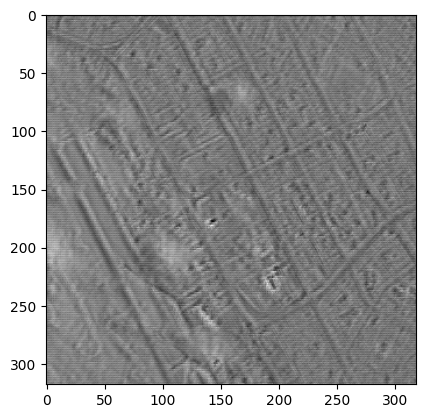

In [9]:
# Image preprocessing
s2_l1c_data_tensor = torch.from_numpy(s2_l1c_data)
s2_l1c_data_tensor = s2_l1c_data_tensor.to(torch.float32)
s2_l1c_data_tensor = s2_l1c_data_tensor.to(device)
# Crop image such that after 8 convolutions are 4 poolings, the dimensions are always even
s2_l1c_data_tensor = s2_l1c_data_tensor[:, 0:508, 0:508]

# Apply everything via the U-net architecture
u_net_arch = u_net()
img_out = u_net_arch(s2_l1c_data_tensor)

mash_colour_channel(img_out)

# Training Stage Sandpit

# New Section

In [10]:
# Sandpit - for debugging and troubleshooting
# Seed for randomness - keeps the initial parameter values consistent
torch.manual_seed(27)

# Sanity Check: Display u-net architecture's parameters
u_net_arch = u_net()
# Reinitialise u_net model
logger.debug(f"{list(u_net_arch.parameters()) = }")

# Training Stage

In [11]:
# Preparation for auto iterating and downloading requesite data
l1c_fileNames = [
    "cloudsen12-l1c.0000.part.taco", # Installed - 2025.10.01
    "cloudsen12-l1c.0001.part.taco", # Installed - 2025.10.01
    "cloudsen12-l1c.0002.part.taco", # --
    "cloudsen12-l1c.0003.part.taco", # --
    "cloudsen12-l1c.0004.part.taco"  # --
  ]

from huggingface_hub import hf_hub_download
import os.path

# Searches for imported datasets. If none are found download
if os.path.isfile("/content/datasets/cloudsen12-l1c.0000.part.taco") == False:
  logger.info(f"The requisite datasets have not been installed.\n\t\t\t\t\t"
      "Please wait until the datasets is been installed from huggingface.\n\t\t\t\t\t"
      "This will take a long time approximately 5+ minutes")

  # 20GB download requires significant time - execute sparingly takes roughly 5 minutes to fully execute
  # Downloads data from huggingface and stores it in Colab file system which is reset on every startup
  dataset_0 = hf_hub_download(
      "tacofoundation/cloudsen12",
      "cloudsen12-l1c.0000.part.taco",
      repo_type = "dataset",
      revision = "f9490f7de11b4f387f72ef800e73ccbb754711de",
      local_dir = "/content/datasets" # Path to save dataset on Colab
  )
  logger.info(f"cloudsen12-l1c.0000.part.taco has been installed.")

  # dataset_1 = hf_hub_download(
  #     "tacofoundation/cloudsen12",
  #     "cloudsen12-l1c.0001.part.taco",
  #     repo_type = "dataset",
  #     revision = "f9490f7de11b4f387f72ef800e73ccbb754711de",
  #     local_dir = "/content/datasets" # Path to save dataset on Colab
  # )
  # logger.info(f"cloudsen12-l1c.0001.part.taco has been installed.")
  logger.info(f"The requisite datasets have been installed.")
else:
  logger.info(f"The requisite datasets have already been been installed.\n\t\t\t\t\t"
      "No further action is required.")
  # Ensure that the file is referenced in the local variable memory - TODO
  #with open("/content/datasets/cloudsen12-l1c.0000.part.taco") as file:
  #  exec(dataset1 = file)

2025-10-09 09:20:08,665 __main__ INFO:	The requisite datasets have not been installed.
					Please wait until the datasets is been installed from huggingface.
					This will take a long time approximately 5+ minutes
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


cloudsen12-l1c.0000.part.taco:   0%|          | 0.00/20.0G [00:00<?, ?B/s]

2025-10-09 09:24:47,847 __main__ INFO:	cloudsen12-l1c.0000.part.taco has been installed.
2025-10-09 09:24:47,849 __main__ INFO:	The requisite datasets have been installed.


In [12]:
# Load data into one massive folder - split afterwards into seperate training and testing data
DATA = tacoreader.load(file = ["/content/datasets/cloudsen12-l1c.0000.part.taco", "/content/datasets/cloudsen12-l1c.0001.part.taco"])

# TODO - not currently used - determine how to use this item - uses the tortilla data format
SUB_DATA = DATA[(DATA["tortilla:data_split"] == "test") & (DATA["label_type"] == "high") & (DATA["real_proj_shape"] == 508)]

Error processing file /content/datasets/cloudsen12-l1c.0001.part.taco: File does not exist or unsupported protocol: /content/datasets/cloudsen12-l1c.0001.part.taco. Supported protocols: s3, gs, az, oss, swift, http, https, ftp, and hf.


In [13]:
# Read a SINGULAR sample - TODO remove - unneeded
sample_idx = 500 # Just change this!
lr = DATA.read(sample_idx).read(0)
hr = DATA.read(sample_idx).read(1)

# Retrieve the data
with rio.open(lr) as src, rio.open(hr) as dst:
    lr_data = src.read([4, 3, 2],window=rio.windows.Window(0, 0, 508, 508))
    hr_data = dst.read(window=rio.windows.Window(0, 0, 508, 508))

# mash_colour_channel(torch.from_numpy(lr_data))

In [14]:
# TODO create docstring for function

def extract_data(sample_idx):
  # Reads only 1 sample from the saved DATA dataset
  # Cannot use the SUB_DATA variable for some reason
  img_data = DATA.read(sample_idx).read(0)
  lbl_data = DATA.read(sample_idx).read(1)

  # Retrieve the data
  # with rio.open(img_data) as src, rio.open(lbl_data) as dst:
      # s2_l1c_data = src.read([4, 3, 2],window = rio.windows.Window(0, 0, 512, 512))
      # s2_label_data = dst.read(window=rio.windows.Window(0, 0, 512, 512))

  with rio.open(img_data), rio.open(lbl_data):
    # Image input is 508x508 pixels so that u-net works best
    s2_l1c_data = rio.open(img_data).read(window=rio.windows.Window(0, 0, 508, 508)) / 10_000  # (13, 512, 512) ndarray (numpy)
    s2_label_data = rio.open(lbl_data).read(window=rio.windows.Window(0, 0, 508, 508))

  # Output relevant datasets
  return s2_l1c_data, s2_label_data

# img, label = extract_data(sample_idx = 4)
# mash_colour_channel(torch.from_numpy(img))
# mash_colour_channel(torch.from_numpy(label))

# img, label = extract_data(sample_idx = 7)
# mash_colour_channel(torch.from_numpy(img))
# mash_colour_channel(torch.from_numpy(label))

In [15]:
# The code done here follows the example methodologies shown in introduction to PyTorch

# Problem breakdown and requirements:

#   Need to import training data
#   -> breakdown into training and testing datasets
#   -> datasets must be cropped and converted into valid filetype
#   Need to import labels
#   -> datatype?
#   -> labels must be cropped and converted into valid filetype

# Need to evaluate success and labels

# WORK IN PROGRESS
#   Define the working datasets:
#   TODO CHECK DIMENSIONS
#   imported datasets are: img [z,x,y,i?], labels [x,y,i?]

#   Relies on assumptions of the quality of the imported data

# Train and testing ratio
DATASET_AMOUNT = 40
tt_ratio = 0.8
TRAIN_AMOUNT = int(DATASET_AMOUNT * tt_ratio)
TEST_AMOUNT = DATASET_AMOUNT - TRAIN_AMOUNT

# Preallocate memory for traing and testing datasets
train_img = numpy.empty(shape = (TRAIN_AMOUNT, 13, 508, 508))
train_img.fill(None)

train_label = numpy.empty(shape = (TRAIN_AMOUNT, 508, 508))
train_label.fill(None)

test_img = numpy.empty(shape = (TEST_AMOUNT, 13, 508, 508,))
test_img.fill(None)

test_label = numpy.empty(shape = (TEST_AMOUNT, 508, 508,))
test_label.fill(None)

# Splits and seperates the data into traing and testing segments
for i in range(DATASET_AMOUNT):
  img_in, label_in = extract_data(sample_idx = i)

  # store into training and testing
  if i < TRAIN_AMOUNT:
    train_img[i][:][:][:] = img_in
    train_label[i][:][:] = label_in
    logger.debug(f"{i} train")
  else:
    test_img[i - TRAIN_AMOUNT][:][:][:]  = img_in
    test_label[i  - TRAIN_AMOUNT][:][:] = label_in
    logger.debug(f"{i} test")

# Convert to tensors!
train_img = torch.from_numpy(train_img)
train_label = torch.from_numpy(train_label)
test_img = torch.from_numpy(test_img)
test_label = torch.from_numpy(test_label)
# Convert to standard float32 tensors!
train_img = train_img.to(torch.float32)
train_label = train_label.to(torch.float32)
test_img = test_img.to(torch.float32)
test_label = test_label.to(torch.float32)

# Resulting tensors
tensor_info(train_img, "combined train_img data")
tensor_info(train_label, "combined train_label data")
tensor_info(test_img, "combined test_img data")
tensor_info(train_label, "combined train_label data")

# -----------------------------------------------------------------------------------------------------------
# TODO Accessing data recommendations: "https://colab.research.google.com/drive/1U9n40rwdnn73bdWruONA3hIs1-H3f74Q"

2025-10-09 09:24:51,878 __main__ INFO:	Tensor:			combined train_img data
2025-10-09 09:24:51,879 __main__ INFO:	Output Datatype:	torch.float32
2025-10-09 09:24:51,885 __main__ INFO:	Output Shape:		torch.Size([32, 13, 508, 508])
2025-10-09 09:24:51,886 __main__ INFO:	Output Size:		torch.Size([32, 13, 508, 508])
2025-10-09 09:24:51,887 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-09 09:24:51,888 __main__ INFO:	Tensor:			combined train_label data
2025-10-09 09:24:51,888 __main__ INFO:	Output Datatype:	torch.float32
2025-10-09 09:24:51,889 __main__ INFO:	Output Shape:		torch.Size([32, 508, 508])
2025-10-09 09:24:51,890 __main__ INFO:	Output Size:		torch.Size([32, 508, 508])
2025-10-09 09:24:51,890 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-09 09:24:51,892 __main__ INFO:	Tensor:			combined test_img data
2025-10-09 09:24:51,892 __main__ INFO:	Output Datatype:	torch.float32
2025-1

In [16]:
# For Debug
# todo - delete - [train_img, train_label, test_img, test_label]

def view_img(index_i, img_bundle, img_bundle_name):
  tensor_info(img_bundle[index_i][:][:][:], "img_bundle_name " + str(index_i))
  mash_colour_channel(img_bundle[index_i][:][:][:])

# view_img(1, train_img, "train_img")
# view_img(7, test_img, "test_img")
# view_img(19, test_img, "test_img")
# view_img(79, train_img, "train_img")

todo 02.10.2025 Thursday W8+1. Finalised 06.10.2025 Monday W9+1

Tried to save data the "stupidest" way possible. Iterate through a dataset - get data individually and then load data to a common array variable.

problems:
> - incorrect datatype -  need a numpy object of a certain size/parameters
> - need to collect imgs into single item - missing dimensions from bad appending
> - need to seperate between training and testing - do after the main dataset variable is created.
> - user defined label is cropped to fit u-net output

- need to sort: geographically, camerawise etc.

Codebase is completed under "stupid" method.

# Inference Model

In [25]:
import torchvision.transforms.functional as ttF

# Prelabeled image
label1  = test_label[1][:][:]
# tensor_info(label1, "label1")
# Predicted image
pred = u_net_arch(test_img[1][:][:][:])
pred = torch.squeeze(pred)
# tensor_info(pred, "u-net predicted + squeeze")

# Remove unnecessary dimension

# Making Prelabeled image's dimensions equal the predicted image's dimensions.
label1_resize1 = ttF.resize(label1.unsqueeze(0), size = (318, 318))
label1_resize2 = label1_resize1.squeeze(0)

# Resultant output - to remove after debug (todo)
# tensor_info(label1_resize1, "label1_resize1 unsqueeze") #
# tensor_info(label1_resize2, "label1_resize2 squeeze")

# mash_colour_channel(label1) #
# mash_colour_channel(label1_resize1) #
# mash_colour_channel(label1_resize2) #

In [26]:
# ---------------------------------------------------------
# todo recommendations:
# Refer to: https://pyimagesearch.com/2021/11/08/u-net-training-image-segmentation-models-in-pytorch/

# use IOU - intersection over union loss class to determine missing values
# aim to minimalise cross-entropy loss - torch.nn.CrossEntropyLoss()

# save the model via
# .mkdir
# .torch.save(u_net_arch.state_dict(), file_path)

# Adam optimiser is recommended
# lossFunc - BCEWithLogitsLoss()

# Gradients are only used for learning or backpropagating - torch.torch_no_grad()
# ---------------------------------------------------------

# TRAINING_LENGTH = 100 # CONTROLS NUMBER OF TRAINING CYCLES
TRAINING_LENGTH = TRAIN_AMOUNT #int(TRAIN_AMOUNT * tt_ratio)

# Allow for parameters of model to be randomised.
weights = nn.Parameter(
    torch.randn(1, dtype = torch.float32),
    requires_grad = True
  )

# loss and optimiser functions
loss_fn = nn.L1Loss() # TODO MAE loss is same as L1Loss
optimiser_fn = torch.optim.SGD(
    params = u_net_arch.parameters(), # parameters to be optimised
    lr = 0.01 # learning rate (how much the optimizer should change parameters at each step, higher=more (less stable), lower=less (might take a long time))
)


for epoch in range(TRAINING_LENGTH):
  u_net_arch.train() # In Training Mode - Default

  train_predict = u_net_arch(train_img[epoch][:][:][:]) # intiial forward pass of model
  train_predict = torch.squeeze(train_predict) # make 2D, comparable to "training_label"

  # DEBUG
  logger.info(f"f{epoch = }")
  # tensor_info(train_predict, epoch) # output for label_predict tensor is [1 (removed), 318, 318]

  # Reduces size from 1x508x508 to 1x318x318 (u-net output) (preprocessing the train_label data)
  train_label_epoch = ttF.resize(train_label[epoch][:][:].unsqueeze(0), size = (318, 318))
  train_label_epoch = train_label_epoch.squeeze(0) # remove unnecessary dimension

  # loss requires a likewise similar value - need to find alternative method or change inference method
  loss = loss_fn(train_predict, train_label_epoch) # loss value is generated

  optimiser_fn.zero_grad() # optimised via zero grad

  loss.backward() # loss back propagation

  optimiser_fn.step() # progress the optimiser

  # Evaluate and test the model
  u_net_arch.eval()

  # need to find a more appropiate method of training data
  # original example had everything stored in one massive variable which was iterated through by the model
  # current setup requires manually iterating through each instance
  with torch.inference_mode():
    for test_epoch in range(TEST_AMOUNT):

      # 1. Forward pass on test data
      test_predict = u_net_arch(test_img[test_epoch][:][:][:])
      test_predict = torch.squeeze(test_predict) # make 2D, comparable to "training_label"

      # 2. Caculate loss on test data

      # 2.1 Resize "test_label" to match "test_pred's" dimensions
      test_label_epoch = ttF.resize(test_label[test_epoch][:][:].unsqueeze(0), size = (318, 318))
      test_label_epoch = test_label_epoch.squeeze(0) # remove unnecessary dimension
      # 2.2 Find loss of model
      test_loss = loss_fn(test_predict, test_label_epoch) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

2025-10-09 11:39:36,133 __main__ INFO:	fepoch = 0
2025-10-09 11:39:49,878 __main__ INFO:	fepoch = 1
2025-10-09 11:40:01,470 __main__ INFO:	fepoch = 2
2025-10-09 11:40:12,279 __main__ INFO:	fepoch = 3
2025-10-09 11:40:22,844 __main__ INFO:	fepoch = 4
2025-10-09 11:40:34,164 __main__ INFO:	fepoch = 5
2025-10-09 11:40:45,325 __main__ INFO:	fepoch = 6
2025-10-09 11:40:56,461 __main__ INFO:	fepoch = 7
2025-10-09 11:41:07,647 __main__ INFO:	fepoch = 8
2025-10-09 11:41:19,938 __main__ INFO:	fepoch = 9
2025-10-09 11:41:34,682 __main__ INFO:	fepoch = 10
2025-10-09 11:41:46,837 __main__ INFO:	fepoch = 11
2025-10-09 11:41:58,995 __main__ INFO:	fepoch = 12
2025-10-09 11:42:10,108 __main__ INFO:	fepoch = 13
2025-10-09 11:42:23,628 __main__ INFO:	fepoch = 14
2025-10-09 11:42:37,417 __main__ INFO:	fepoch = 15
2025-10-09 11:42:49,159 __main__ INFO:	fepoch = 16
2025-10-09 11:43:00,452 __main__ INFO:	fepoch = 17
2025-10-09 11:43:11,073 __main__ INFO:	fepoch = 18
2025-10-09 11:43:21,846 __main__ INFO:	fe

In [40]:
# Find our model's learned parameters ONLY in debug mode
logger.debug("The model learned parameters:")
logger.debug(u_net_arch.state_dict())

# Saves the model's learned parameters (state dictionary) to a file
if os.path.exists("/content/datasets/model_parameters") == False:
  os.mkdir("/content/datasets/model_parameters")

torch.save(u_net_arch.state_dict(), "/content/datasets/model_parameters/u_net_arch.pt")

In [19]:
# save the state_dict to a directory and download to shorten exercution time 09.10.2025

2025-10-09 11:32:16,260 __main__ INFO:	The PREDICTED TEST LABEL from the original test image
2025-10-09 11:32:16,262 __main__ INFO:	The image resolution is (318, 318)
2025-10-09 11:32:16,263 __main__ INFO:	The number of colour channels are 1


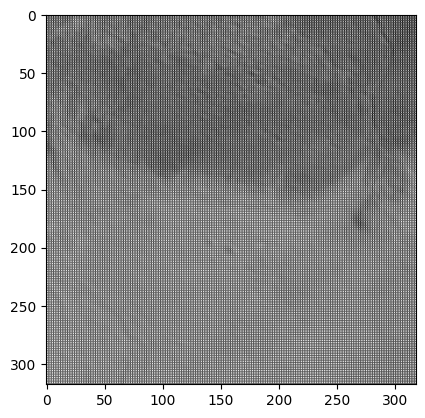

2025-10-09 11:32:16,442 __main__ INFO:	The ORIGINAL TEST IMAGE
2025-10-09 11:32:16,446 __main__ INFO:	The image resolution is (508, 508)
2025-10-09 11:32:16,447 __main__ INFO:	The number of colour channels are 13


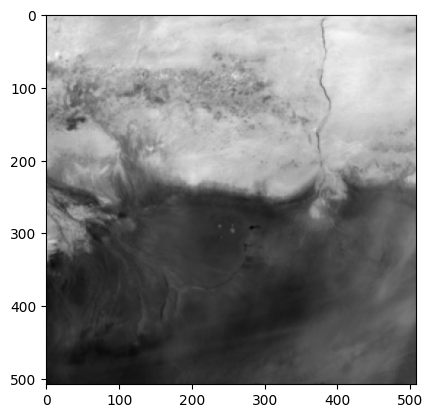

2025-10-09 11:32:16,641 __main__ INFO:	The ORIGINAL TEST LABEL
2025-10-09 11:32:16,643 __main__ INFO:	The image resolution is (508, 508)
2025-10-09 11:32:16,644 __main__ INFO:	The number of colour channels are 1


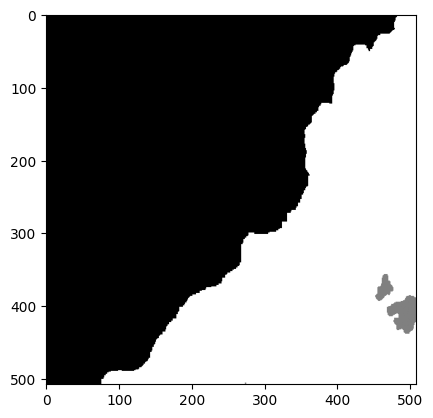

In [23]:
u_net_arch.eval()

# Making a prediction - use to evaluate the validity of the dataset
with torch.inference_mode():
  label_eval_predict = u_net_arch(test_img[1][:][:][:])
  logger.info(f"The PREDICTED TEST LABEL from the original test image")
  mash_colour_channel(label_eval_predict)

logger.info(f"The ORIGINAL TEST IMAGE")
mash_colour_channel(test_img[1][:][:][:])
logger.info(f"The ORIGINAL TEST LABEL")
mash_colour_channel(test_label[1][:][:])
# create graphical method of visualising code

# todo:

main requirements:
1. *work out how to transfer images and visualise progress*
2. determine required images and what I should use
---
Datahandling:

1. > Need to determine how to import multiple datavalues
2. > Need to determine how many training and testing datasets there are
3. > Need to determine method of seperating datasets
4. > Need to determine if subset / SUB_DATA methodology works.

Do I need to create a proper datahandler?

---

3. being to save progress with model fitting
4. make the model tech agnostic
5. Get a logger setup - requires a working file directory
```
import logging
self.logger = logging.getLogger(__name__)
```
## todo big picture:
1. **DONE!** get rough model working
2. **DONE!** build the Unet model

##Useful knowledge:
1. keyboard shortcut to comment and uncomment out things is ctrl + "/"**bold text**
2. The U-net model requires that the encoder/decoder colour channel follows the following pattern: 1 - 64 - 128 - 256 - 512
3. Refer to "https://stackoverflow.com/questions/57530038/concatenation-step-of-u-net-for-unequal-number-of-channels" for more information
4. Unsqueeze 2 dimensional tensors to use the mash_colour_channels() functional (prints off an image in greyscale).
5. > represents a task which has been completed

## CloudSEN12+ dataset information:
(Further information about CloudSEN12+ dataset)

1. The Huggingface website: https://huggingface.co/datasets/tacofoundation/cloudsen12
Explains the overall picture of the dataset types

2. https://www.scidb.cn/en/detail?dataSetId=2036f4657b094edfbb099053d6024b08&version=V1
Explains historical dataset formatting - we are interested in  p509 has some further details. Investigate: *p509-> high -> train*

## Additional References:

Sam Hall's References:
- OBAI Cloud Detection tutorial: https://source.coop/radiantearth/cloud-cover-detection-challenge
- OBAI recommendations independent of ECSS: https://ieeexplore.ieee.org/document/10558221